In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

# 1a

def AR2(xi, sigma2, N):   
    # get parameters
    xi1, xi2 = xi

    # compute the AR(2) coefficients
    a1 = 1/xi1 + 1/xi2   
    a2 = -1/(xi1*xi2)    
    
    # use Brockwell & Davis closed-form for
    # s0 = Var(X0) and s1 = Cov(X0, X_{-1})
    denominator   = (xi1*xi2 - 1) * (xi2 - xi1)/(xi1**2 * xi2**2)
    nume_s0 = xi1/(xi1**2 - 1) - xi2/(xi2**2 - 1)
    s0 = sigma2 * nume_s0 / denominator   
    
    nume_s1 = 1/(xi1**2 - 1) - 1/(xi2**2 - 1)
    s1 = sigma2 * nume_s1 / denominator   
    
    # covariance matrix required in the question
    D = np.array([[s0, s1],[s1, s0]])

    # I consistently went into the error of Matrix is not positive definite
    # when applying cholesky so I decide to add enough eps to make the matrix pd
    eps = 1e-8
    for _ in range(10):
        try:
            C = np.linalg.cholesky(D + eps*np.eye(2))
            break
        except np.linalg.LinAlgError:
            eps *= 10
    else:
        raise np.linalg.LinAlgError("Cannot regularize D to be PD with closed-form s0,s1.")
    
    # initial two observations ~ N(0, D)
    Y = np.random.normal(size=(2, 1))
    X = C @ Y
    
    # store the first two values and want them recursively
    X_series = [X[0, 0], X[1, 0]]
    
    # genereate AR2 process with X_t = a1 * X_{t-1} + a2 * X_{t-2} + e_t
    for t in range(2, N+2):
        noise = np.random.normal(0, np.sqrt(sigma2)) # e_t
        X_t = a1 * X_series[t-1] + a2 * X_series[t-2] + noise
        X_series.append(X_t)
 
    return X_series[2:]

In [125]:
# 1b
import numpy as np
import sympy

#  estimated covariance matrix
def estimated_cmatrix(samples):
    """
    If 'samples' is a list of M sample vectors each of length N,
    returns the N x N matrix (1/M)*sum_j x_j x_j^T (assuming zero mean).
    """
    M = len(samples)
    N = len(samples[0])
    cov_matrix = np.zeros((N, N))
    for x in samples:
        cov_matrix += np.outer(x, x)
    cov_matrix /= M
    return cov_matrix

# ----------------------
#  TRUE AR(2) ACVS  (YULE-WALKER)
# ----------------------
def true_AR2(xi, sigma2, max_lag=5):
    """
    Solve Yule-Walker for s0,s1,s2, then s3..s_{max_lag}.
    Returns [s0, s1, ..., s_{max_lag}].
    """
    xi1, xi2 = xi
    a1 = 1/xi1 + 1/xi2
    a2 = -1/(xi1*xi2)

    s0_sym, s1_sym, s2_sym = sympy.symbols('s0 s1 s2', real=True)
    eqs = [
        sympy.Eq(s1_sym, a1*s0_sym + a2*s1_sym),
        sympy.Eq(s2_sym, a1*s1_sym + a2*s0_sym),
        sympy.Eq(s0_sym, a1*s1_sym + a2*s2_sym + sigma2)
    ]
    sol = sympy.solve(eqs, [s0_sym, s1_sym, s2_sym], dict=True)[0]
    s0_val = float(sol[s0_sym])
    s1_val = float(sol[s1_sym])
    s2_val = float(sol[s2_sym])

    svals = [s0_val, s1_val, s2_val]
    for k in range(3, max_lag+1):
        s_next = a1*svals[k-1] + a2*svals[k-2]
        svals.append(s_next)
    return svals

# ----------------------
#  TRUE TOEPLITZ (N=6)
# ----------------------
def build_true_toeplitz_cov(xi, sigma2, N=6):
    """
    Build the N x N Toeplitz covariance matrix for the AR(2)
    i.e. T[i,j] = s_{|i-j|}
    where s_k are from true_AR2(...) up to k=N-1.
    """
    svals = true_AR2(xi, sigma2, max_lag=N-1)
    T = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            lag = abs(i-j)
            T[i,j] = svals[lag]
    return T

# squared_error
def squared_error(vec_true, vec_est):
    return np.sum((np.array(vec_true) - np.array(vec_est))**2)

# parameters
xi  = (10/9, 2)
sigma2 = 1.0
N = 6

Ms = [100,150,200,250,300,350,400,450,500]
num_repeats = 500

# the "true" autocov row => s0..s5
svals_true = true_AR2(xi, sigma2, max_lag=5)

# We'll store the a_bar values here:
a_bar_values = []

for M in Ms:
    errors = []
    cov_sum = np.zeros((N, N))

    for _ in range(num_repeats):
        # generate M independent X_1..X_6 from AR(2)
        samples = [AR2(xi, sigma2, N) for __ in range(M)]
        
        # estimate 6x6 cov
        cov_est = estimated_cmatrix(samples)
        
        # extract first row => s^_0..s^_5
        s_hat_row = cov_est[0,:]
        
        # compare to [s0..s5]
        err_val = squared_error(svals_true, s_hat_row)
        errors.append(err_val)

        # if M=500, accumulate for average 6x6
        if M == 500:
            cov_sum += cov_est

    mean_err = np.mean(errors)  # average a
    a_bar_values.append(mean_err)

    print(f"M={M}, average error a-bar over {num_repeats} repeats = {mean_err:.6f}")

    # if M=500, finalize and print average 6x6
    if M == 500:
        avg_cov = cov_sum / num_repeats
        print("\n=== For M=500, average sample covariance matrix ===")
        print(avg_cov)

        true_cov = build_true_toeplitz_cov(xi, sigma2, N)
        print("\n=== True Toeplitz covariance ===")
        print(true_cov)

print("\nAll a_bar values for M:", Ms)
print("a_bar_values =", a_bar_values)


M=100, average error a-bar over 500 repeats = 39.610862
M=150, average error a-bar over 500 repeats = 24.885056
M=200, average error a-bar over 500 repeats = 18.556105
M=250, average error a-bar over 500 repeats = 14.670713
M=300, average error a-bar over 500 repeats = 12.821599
M=350, average error a-bar over 500 repeats = 10.760491
M=400, average error a-bar over 500 repeats = 9.114373
M=450, average error a-bar over 500 repeats = 8.561423
M=500, average error a-bar over 500 repeats = 6.860369

=== For M=500, average sample covariance matrix ===
[[18.44084721 17.82415595 16.65401139 15.31041424 13.9491105  12.63483294]
 [17.82415595 18.48354785 17.85861519 16.69848171 15.35169342 13.97539129]
 [16.65401139 17.85861519 18.51026453 17.89056708 16.72782421 15.36367665]
 [15.31041424 16.69848171 17.89056708 18.54580918 17.92457905 16.74706582]
 [13.9491105  15.35169342 16.72782421 17.92457905 18.57738347 17.93987078]
 [12.63483294 13.97539129 15.36367665 16.74706582 17.93987078 18.576175

N=100, average error b-bar = 427.162934
N=150, average error b-bar = 298.091060
N=200, average error b-bar = 214.415382
N=250, average error b-bar = 208.568606
N=300, average error b-bar = 149.162269
N=350, average error b-bar = 134.965408
N=400, average error b-bar = 109.033783
N=450, average error b-bar = 99.920082
N=500, average error b-bar = 99.215084


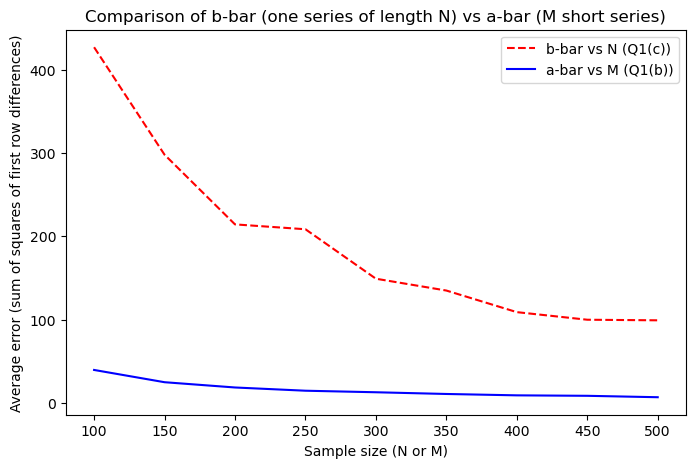

In [127]:
# 1(c)

import numpy as np
import matplotlib.pyplot as plt

def estimate_acv(X, max_tau=5):
    """
    For a single series X of length N, estimate
      hat s_tau = (1/N)*sum_{t=1}^{N-tau}(X_t * X_{t+tau}), tau=0..5
    Returns [s0, s1, ..., s5].
    """
    N = len(X)
    acov = []
    for tau in range(max_tau+1):
        total = 0.0
        for t in range(N - tau):
            total += X[t]*X[t+tau]
        s_tau = total/N
        acov.append(s_tau)
    return acov

# We'll do the same approach as Q1(b)
xi  = (10/9, 2)
sigma2 = 1.0
N_list = [100,150,200,250,300,350,400,450,500] 
num_repeats = 500

# true values
true_svals = true_AR2(xi, sigma2, max_lag=5)

# collect the b-bar values for each N
b_bar_values = []

for N in N_list:
    errors = []
    for _ in range(num_repeats):
        # Generate one AR(2) series of length N
        X = AR2(xi, sigma2, N)
        # Estimate s^_0..s^_5
        shat = estimate_acv(X)
        # b = sum_{j=0..5} (shat_j - s_j)^2
        e = np.sum((np.array(shat) - np.array(true_svals))**2)
        errors.append(e)
    b_bar = np.mean(errors)
    b_bar_values.append(b_bar)
    print(f"N={N}, average error b-bar = {b_bar:.6f}")

# PLOT Q1(c) results (b-bar) vs Q1(b) results (a-bar)
plt.figure(figsize=(8,5))
plt.plot(N_list, b_bar_values, 'r--', label="b-bar vs N (Q1(c))")

# Plot the a_bar results from Q1(b) on the same figure, but in a solid line
# Assume you have them in 'a_bar_values':
plt.plot(M_list, a_bar_values, 'b-', label="a-bar vs M (Q1(b))")

plt.xlabel("Sample size (N or M)")
plt.ylabel("Average error (sum of squares of first row differences)")
plt.title("Comparison of b-bar (one series of length N) vs a-bar (M short series)")
plt.legend()
plt.show()


[White Noise part(b)] M=100, a-bar=0.07055
[White Noise part(b)] M=150, a-bar=0.04727
[White Noise part(b)] M=200, a-bar=0.03586
[White Noise part(b)] M=250, a-bar=0.02791
[White Noise part(b)] M=300, a-bar=0.02297
[White Noise part(b)] M=350, a-bar=0.01932
[White Noise part(b)] M=400, a-bar=0.01743
[White Noise part(b)] M=450, a-bar=0.01477
[White Noise part(b)] M=500, a-bar=0.01362
[White Noise part(c)] N=100, b-bar=0.06721
[White Noise part(c)] N=150, b-bar=0.04796
[White Noise part(c)] N=200, b-bar=0.03594
[White Noise part(c)] N=250, b-bar=0.02854
[White Noise part(c)] N=300, b-bar=0.02308
[White Noise part(c)] N=350, b-bar=0.01997
[White Noise part(c)] N=400, b-bar=0.01697
[White Noise part(c)] N=450, b-bar=0.01554
[White Noise part(c)] N=500, b-bar=0.01433


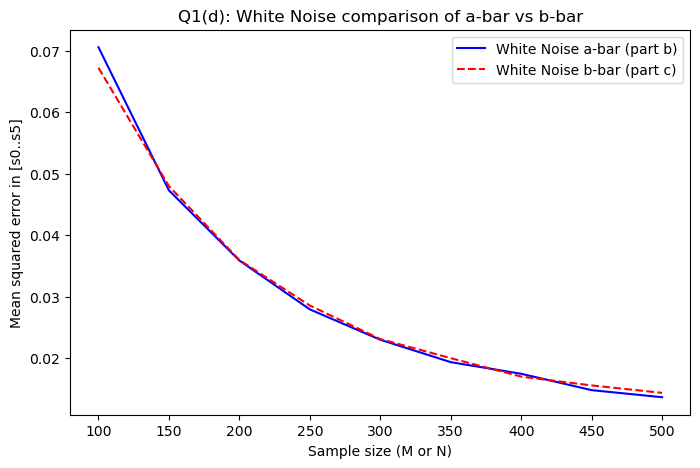

In [131]:
#1d

# White-noise simulator: returns a length-N series of iid N(0, sigma^2).
def simulate_wn(N, sigma2=1.0):
    return np.random.normal(0, np.sqrt(sigma2), size=N)

# True s0..s5 for white noise
def true_wn(sigma2=1.0, max_lag=5):
    """
    For an i.i.d. white noise process with var=sigma^2,
    we have s_0 = sigma^2, s_1..s_5=0.
    """
    svals = [0]*(max_lag+1)
    svals[0] = sigma2  # variance
    return svals

# rewrite partb
def wn_b(M_list, sigma2=1.0, short_len=6, repeats=500):
    true_svals_wn = true_wn(sigma2, max_lag=5)
    a_bar = []

    for M in M_list:
        errors = []
        for _ in range(repeats):
            # Generate M short vectors each length=6
            samples = [simulate_wn(short_len, sigma2=sigma2)
                       for __ in range(M)]
            # estimate the 6x6 covariance
            cov_est = estimated_cmatrix(samples)
            # s-hat row => first row
            s_hat = cov_est[0,:]
            # error => sum of squares vs [s0..s5]
            err = np.sum((s_hat - true_svals_wn)**2)
            errors.append(err)
        mean_err = np.mean(errors)
        a_bar.append(mean_err)
        print(f"[White Noise part(b)] M={M}, a-bar={mean_err:.5f}")
    return a_bar

# rewrite partc
def wn_c(N_list, sigma2=1.0, repeats=500):
    true_svals_wn = true_wn(sigma2, max_lag=5)
    b_bar = []

    for N in N_list:
        errors = []
        for _ in range(repeats):
            # Single series length=N
            X = simulate_wn(N, sigma2=sigma2)
            # estimate s0..s5
            shat = estimate_acv(X, max_tau=5)
            # error => sum squares
            err = np.sum((np.array(shat) - np.array(true_svals_wn))**2)
            errors.append(err)
        mean_err = np.mean(errors)
        b_bar.append(mean_err)
        print(f"[White Noise part(c)] N={N}, b-bar={mean_err:.5f}")
    return b_bar

##############################################################################
# (G) Main for Q1(d) - run both "part b" & "part c" with White Noise,
#     then plot a-bar vs M & b-bar vs N to compare to the AR(2) case
##############################################################################
M_list = [100,150,200,250,300,350,400,450,500]
sigma2 = 1.0
short_len = 6
repeats = 500

# a-bar 
wn_a_bar = wn_b(M_list, sigma2, short_len, repeats)

# b-bar 
wn_b_bar = wn_c(M_list, sigma2, repeats)

#  Plot
plt.figure(figsize=(8,5))
plt.plot(M_list, wn_a_bar, 'b-', label="White Noise a-bar (part b)")
plt.plot(N_list, wn_b_bar, 'r--', label="White Noise b-bar (part c)")
plt.xlabel("Sample size (M or N)")
plt.ylabel("Mean squared error in [s0..s5]")
plt.title("Q1(d): White Noise comparison of a-bar vs b-bar")
plt.legend()
plt.show()


In [39]:
#2a

def difference(data, d):
    if d == 0:
        return data
    diff_data = np.diff(data, n=d)
    return diff_data

def fit_ar(data, p):
    n = len(data)
    x = np.zeros((n - p, p))
    y = np.zeros(n - p)
    
    for i in range(p, n):
        # Reverse the p previous values for each row in x
        x[i - p] = data[i - p:i][::-1]
        # The target value y_i is data[i]
        y[i - p] = data[i]
    
    # Solve the ordinary least squares problem x * phi ≈ y
    phi = np.linalg.lstsq(x, y, rcond=None)[0]
    
    # Compute the residuals and their variance
    residuals = y - x @ phi
    sigma2 = np.mean(residuals**2)
    
    return phi, sigma2

def calculate_aic(data, p, sigma2):
    n = len(data)
    aic = 2 * p + n * np.log(sigma2)
    return aic

def fit_arima(data, p, d):
    diff_data = difference(data, d)
    phi, sigma2 = fit_ar(diff_data, p)
    aic = calculate_aic(data, p, sigma2)
    return phi, sigma2, aic


In [41]:
#2b

def calculate_aic_table(data, p_range, d_range):
    """
    Create a 3x5 table of AIC values for p in [1..5], d in [2..4],
    using the formula AIC = 2p + N ln(sigma^2_epsilon),
    where N = length of the differenced data.
    """
    # Make a 3x5 DataFrame with d as rows and p as columns
    aic_table = pd.DataFrame(index=d_range, columns=p_range, dtype=float)
    
    for d in d_range:
        # d in {2,3,4}
        # difference the data d times
        diff_data = difference(data, d)
        N = len(diff_data)  # length of differenced data

        for p in p_range:
            # Fit AR(p) to diff_data by least squares
            phi, sigma2 = fit_ar(diff_data, p)  # returns (coeffs, residual_variance)
            
            # AIC = 2p + N ln( sigma^2_epsilon )
            aic_value = 2*p + N * np.log(sigma2)
            
            # store in the table at row=d, col=p
            aic_table.loc[d, p] = aic_value

    return aic_table


In [91]:
### 2(c)

# load the Excel file and only use the second column
file = pd.read_excel(r"C:\Users\26379\Desktop\Time Series\time_series_064.xlsx")
full_data = file.iloc[:, 1].to_list()  # data is a list
data1= full_data[:48]

p_range = range(1, 6)
d_range = range(2, 5)

aic_table = calculate_aic_table(data1, p_range, d_range)
best_aic = aic_table.values.min()  # smallest value in the DataFrame

# the best (lowest) AIC value and the corresponding parameters
best_p, best_d = np.where(aic_table == best_aic)

# get the location (row, col) in 0-based indices
best_locs = np.where(aic_table.values == best_aic)
# pick the first match (in case there's a tie)
row_idx = best_locs[0][0]  
col_idx = best_locs[1][0]

# find the actual d, p from the DataFrame index/columns
best_d = aic_table.index[row_idx]
best_p = aic_table.columns[col_idx]

print("Best AIC value:", best_aic)
print(f"Best model is ARIMA(p={best_p}, d={best_d}, q=0).")

# Now get the parameter estimates from the fit (p AR coefficients).
phi, sigma2, _ = fit_arima(data, best_p, best_d)  
print("Estimated AR coefficients:", phi)
print("Residual variance:", sigma2)


Best AIC value: 239.04769730945074
Best model is ARIMA(p=2, d=2, q=0).
Estimated AR coefficients: [-0.32547788 -0.44515716]
Residual variance: 180.3300545884436


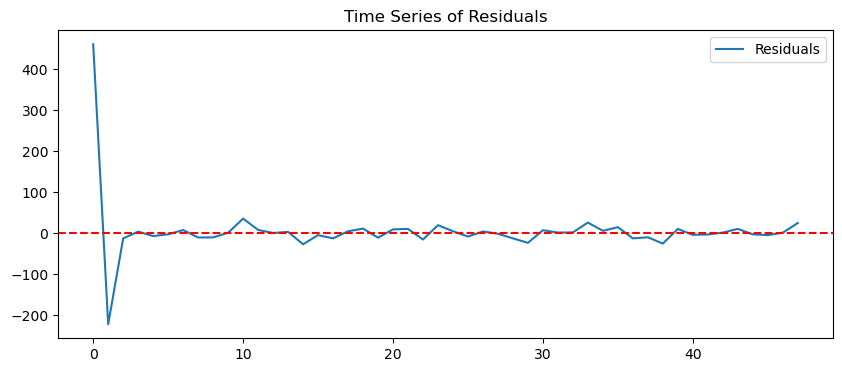

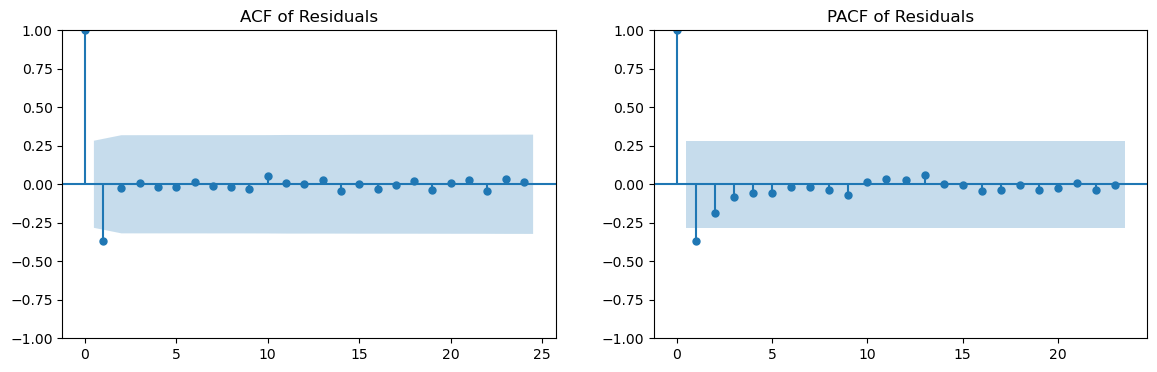

Ljung-Box Test Results (up to lag 24):
     lb_stat  lb_pvalue
1   6.863073        NaN
2   6.897933        NaN
3   6.904006   0.008600
4   6.920602   0.031420
5   6.938489   0.073884
6   6.956388   0.138211
7   6.960705   0.223579
8   6.981816   0.322532
9   7.037432   0.424993
10  7.234651   0.511540
11  7.241841   0.611956
12  7.241841   0.702433
13  7.307171   0.773691
14  7.422821   0.828455
15  7.423176   0.879048
16  7.481783   0.914542
17  7.482807   0.942843
18  7.517485   0.961952
19  7.626507   0.973895
20  7.629817   0.983653
21  7.701101   0.989434
22  7.859946   0.992755
23  7.956768   0.995325
24  7.988533   0.997190


In [109]:
#2d
import statsmodels.api as sm
from scipy.stats import shapiro


# Fit the ARIMA Model
best_model = ARIMA(data1, order=(best_p, best_d, 0))
best_result = best_model.fit()

# Residual Extraction
residuals = best_result.resid

# Plot Residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Time Series of Residuals")
plt.legend()
plt.show()

# ACF/PACF Plots of Residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=24, ax=axes[0], title='ACF of Residuals')

# Partial Autocorrelation
sm.graphics.tsa.plot_pacf(residuals, lags=23, ax=axes[1], title='PACF of Residuals', method='ywm')

plt.show()

# Ljung-Box Test
# The alpha=0.05 argument gives p-values at 5% s.f.
# df is h-p as required
ljung_box_result = acorr_ljungbox(residuals, lags=24, model_df=best_p, return_df=True) 
print("Ljung-Box Test Results (up to lag 24):")
print(ljung_box_result)


In [97]:
#2e

###################### Function by ChatGPT ########################
def predict_arima(data, p, d, steps=12):
    """
    Forecast X_{N+1}..X_{N+steps} from an ARIMA(p,d,0) fit via least squares.
    Returns the forecasts on the *original* (undifferenced) scale.
    """

    # 1) Difference the data d times
    diff_data = difference(data, d)     # e.g. d=2 => second differences
    # 2) Fit AR(p) to the differenced data
    phi, sigma2 = fit_ar(diff_data, p)
    
    # 3) Build an "extended" list so we can do multi‐step in the *differenced* space.
    #    The last p differenced points help us predict the next difference, and so on.
    extended_diff = list(diff_data)
    for h in range(steps):
        # Grab the last p differenced values (most recent first if needed)
        X = extended_diff[-p:]          # shape=(p,)
        X_rev = X[::-1]                 # reverse if fit_ar expects "lag1 first, lag2 second,..."
        forecast_diff = np.dot(phi, X_rev)
        # Append the newly‐predicted difference
        extended_diff.append(forecast_diff)
    
    # The last 'steps' items in extended_diff are the brand‐new forecasted *differences*.
    predicted_diffs = extended_diff[-steps:]
    
    # 4) "Invert" the differencing properly to recover forecasts on the original scale.
    forecasts = invert_differences(data, predicted_diffs, d)
    
    return forecasts


def invert_differences(original_data, predicted_diffs, d):
    """
    Reconstruct forecasts X_{N+1}..X_{N+steps} on the *original* scale
    from the predicted differences, given that we differenced the data d times.
    
    For d=1:   X_{N+h} = X_N + cumsum( ΔX_{N+1}..ΔX_{N+h} ).
    For d=2:   we first reconstruct future 1st differences from 2nd diffs,
               then reconstruct the levels from the last known X_N, etc.
    """
    # Last actual data point is X_N
    last_value = original_data[-1]
    
    if d == 0:
        # No differencing => "predicted_diffs" are already X_{N+1},..,X_{N+steps}.
        return predicted_diffs

    elif d == 1:
        # One difference => X_{N+h} = X_N + sum of predicted diffs up to h
        csum = np.cumsum(predicted_diffs)
        return [last_value + c for c in csum]

    elif d == 2:
        # Two differences => We need the last *first* difference and last X_N.
        # step1: rebuild the future 1st differences by cumulatively summing predicted 2nd diffs
        last_diff1 = original_data[-1] - original_data[-2]  # X_N - X_{N-1}
        
        first_diffs_forecast = []
        running_diff1 = last_diff1
        for diff2 in predicted_diffs:
            running_diff1 += diff2
            first_diffs_forecast.append(running_diff1)
        
        # step2: now rebuild the level X_{N+h} from X_{N} + these new first differences
        # i.e. X_{N+1} = X_N + 1stDiff(N+1), X_{N+2} = X_{N+1} + 1stDiff(N+2), ...
        forecasts = []
        running_level = last_value
        for fd in first_diffs_forecast:
            next_val = running_level + fd
            forecasts.append(next_val)
            running_level = next_val
        
        return forecasts

    else:
        raise NotImplementedError("Code demo covers only d=0,1,2.")


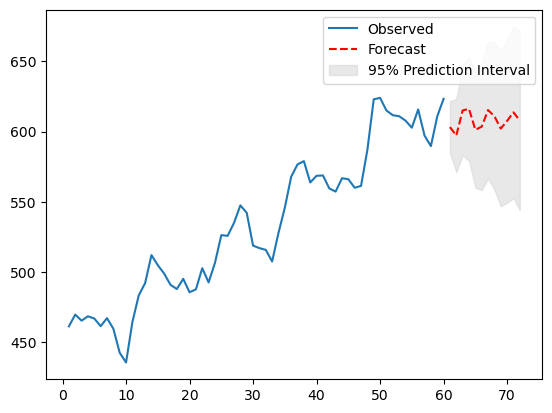

In [99]:
# 2(f)
from scipy.stats import norm

################### Function with GPT ##########################
def predict_arima_with_pi(data, p, d, steps=12, alpha=0.05):
    """
    1) Fit AR(p) to the d-times differenced data
    2) Do multi-step forecasting in differenced space
    3) "Invert" differences to get forecasts on the original scale
    4) Compute naive multi-step forecast stdev => 95% intervals
    Returns (point_forecasts, lower_bounds, upper_bounds).
    """
    # (1) difference + AR fit
    diff_data = difference(data, d)
    phi, sigma2 = fit_ar(diff_data, p)
    sigma_e = np.sqrt(sigma2)  # stdev of d-th differenced noise

    N = len(diff_data)  # length of differenced series

    # (2) multi-step forecast of differenced series
    extended_diff = list(diff_data)  # so we can append new preds
    for h in range(steps):
        last_p = extended_diff[-p:]      # shape p
        # reverse if your phi expects [X_{t-1}, X_{t-2}, ...]
        forecast_diff = np.dot(phi, last_p[::-1])
        extended_diff.append(forecast_diff)

    predicted_diffs = extended_diff[-steps:]

    # (3) invert differences => point forecasts on original scale
    point_forecasts = invert_differences(data, predicted_diffs, d)

    # (4) compute multi-step stdev on original scale.
    # The question's "naive" formulas for a d-th differenced AR:
    #   d=1 => stdev(X_{N+h}) ~ sigma_e * sqrt(h)
    #   d=2 => stdev(X_{N+h}) ~ sigma_e * sqrt(h*(h+1)/2)
    # For d=0, we'll do sigma_e * sqrt(h) for demonstration.
    stdevs = []
    for h in range(1, steps+1):
        if d == 0:
            std_h = sigma_e * np.sqrt(h)
        elif d == 1:
            std_h = sigma_e * np.sqrt(h)
        elif d == 2:
            std_h = sigma_e * np.sqrt(h*(h+1)/2)
        else:
            raise NotImplementedError("Demo for d=0,1,2 only.")

        stdevs.append(std_h)

    # compute 95% intervals => +/- z * stdev
    z_val = abs(norm.ppf(alpha/2))  # ~1.96 for alpha=0.05
    lower_bounds = []
    upper_bounds = []
    for fc, s in zip(point_forecasts, stdevs):
        margin = z_val * s
        lower_bounds.append(fc - margin)
        upper_bounds.append(fc + margin)

    return point_forecasts, lower_bounds, upper_bounds

data2 = full_data[48:]
forecast_vals, lb, ub = predict_arima_with_pi(data2, p=2, d=1, steps=12)

full_time = np.arange(1, len(data)+1)
plt.plot(full_time, data, label='Observed')

future_time = np.arange(len(data)+1, len(data)+1+12)
plt.plot(future_time, forecast_vals, 'r--', label='Forecast')
plt.fill_between(future_time, lb, ub, color='lightgray', alpha=0.5,
                 label='95% Prediction Interval')
plt.legend()
plt.show()



Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=368.078, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=368.431, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=366.675, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=368.822, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=367.112, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=367.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=369.031, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=366.308, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=367.060, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=367.216, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=367.762, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=368.943, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.159 seconds
Best ARIMA order found by auto_arima = (0, 1, 1)
Summary of the chosen model:
                      

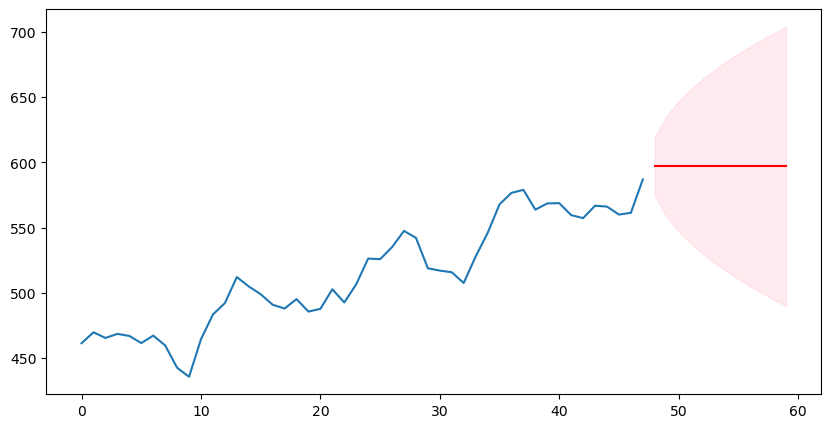

In [111]:
# 2(g)
import pmdarima as pm  

# automatic Model Selection
auto_model = pm.auto_arima(
    data1,                # your time series
    start_p=1, max_p=5,  # range of AR orders to try
    start_q=0, max_q=2,  # range of MA orders to try
    seasonal=False,      # set True if you want seasonal ARIMA
    d=None,              # let auto_arima discover integration order
    trace=True,          # print out progress
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,       # stepwise search
    information_criterion='aic'
)

print("Best ARIMA order found by auto_arima =", auto_model.order)
print("Summary of the chosen model:\n", auto_model.summary())

# forecast 12 steps ahead 
n_forecast = 12
fc, confint = auto_model.predict(n_periods=n_forecast,
                                 return_conf_int=True,
                                 alpha=0.05)  # 95% CI

# indices for plotting
index_of_fc = np.arange(len(data1), len(data1) + n_forecast)

# plot Observed + Forecast + Prediction Interval
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(data1)), data1, label='Observed data')  # X1..X48
plt.plot(index_of_fc, fc, label='Forecast', color='red')
plt.fill_between(index_of_fc,
                 confint[:, 0],  # lower
                 confint[:, 1],  # upper
                 color='pink', alpha=0.3,
                 label='95% Prediction Interval')


In [107]:
# 2(h)
from sklearn.metrics import mean_squared_error

# from 2e we have "p" and "d" that gives best fit
forecast_e = predict_arima(data1, best_p, best_d, steps=12)
# yields a list of 12 forecasts

# from 2g 'fc' is the 12-step forecast from auto_arima
forecast_g = fc  # from the code in Q2(g)

# actual new data X49..X60 is 'data2' of length 12
true_vals = data2  # shape=(12,)

# compute RMSE for each model
rmse_e = np.sqrt(mean_squared_error(true_vals, forecast_e))
rmse_g = np.sqrt(mean_squared_error(true_vals, forecast_g))

print(f"Part (e) ARIMA(p={best_p}, d={best_d}, 0) RMSE: {rmse_e:.4f}")
print(f"Part (g) auto_arima RMSE: {rmse_g:.4f}")

# determine which model performed better
if rmse_g < rmse_e:
    print("=> Part (g) model performed better (lower RMSE).")
else:
    print("=> Part (e) model performed better (lower RMSE).")


Part (e) ARIMA(p=2, d=2, 0) RMSE: 76.6074
Part (g) auto_arima RMSE: 17.2764
=> Part (g) model performed better (lower RMSE).
